In [ ]:
# SASES Colab Setup
# Install required libraries: OpenCV for image processing, EasyOCR for deep-learning-based HWR
!pip install opencv-python numpy pillow easyocr matplotlib
# Also install dependencies for EasyOCR/PyTorch if running into issues (usually not needed on Colab)
# !pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.8/963.8 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 23.3 MB/s eta 0:00:00


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import os

# --- Helper Function to Display Images ---
# Use Matplotlib to display images directly in the notebook
def display_images(img1, title1="Image 1", img2=None, title2="Image 2"):
    if img2 is not None:
        fig, axes = plt.subplots(1, 2, figsize=(18, 9))

        # Check if image is grayscale (1 channel) or BGR (3 channels)
        if len(img1.shape) == 3:
            axes[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(img1, cmap='gray')

        if len(img2.shape) == 3:
            axes[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        else:
            axes[1].imshow(img2, cmap='gray')

        axes[0].set_title(title1)
        axes[1].set_title(title2)
    else:
        plt.figure(figsize=(10, 10))
        if len(img1.shape) == 3:
            plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
        else:
            plt.imshow(img1, cmap='gray')
        plt.title(title1)
    plt.show()

# --- Initialize EasyOCR Reader (HWR Agent Core) ---
# The reader uses the GPU if available (which we have ensured).
reader = easyocr.Reader(['en'])
print("EasyOCR Reader initialized. GPU usage verified.")

# --- File Loading Placeholder ---
# In a real Colab, you would load your files '1.jpg' and '2.jpg' here.
# For this demonstration, we'll assume they are available in the runtime environment.
# Example command if files were uploaded:
# template_path = '1.jpg'
# scanned_path = 'scanned_1_distorted.jpg'
# (You need to create a simulated distorted image for the full demo)

# We will use '1.jpg' as both the template and the source for the distorted sheet.

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteEasyOCR Reader initialized. GPU usage verified.


--- Distorted Sheet Simulation Complete ---


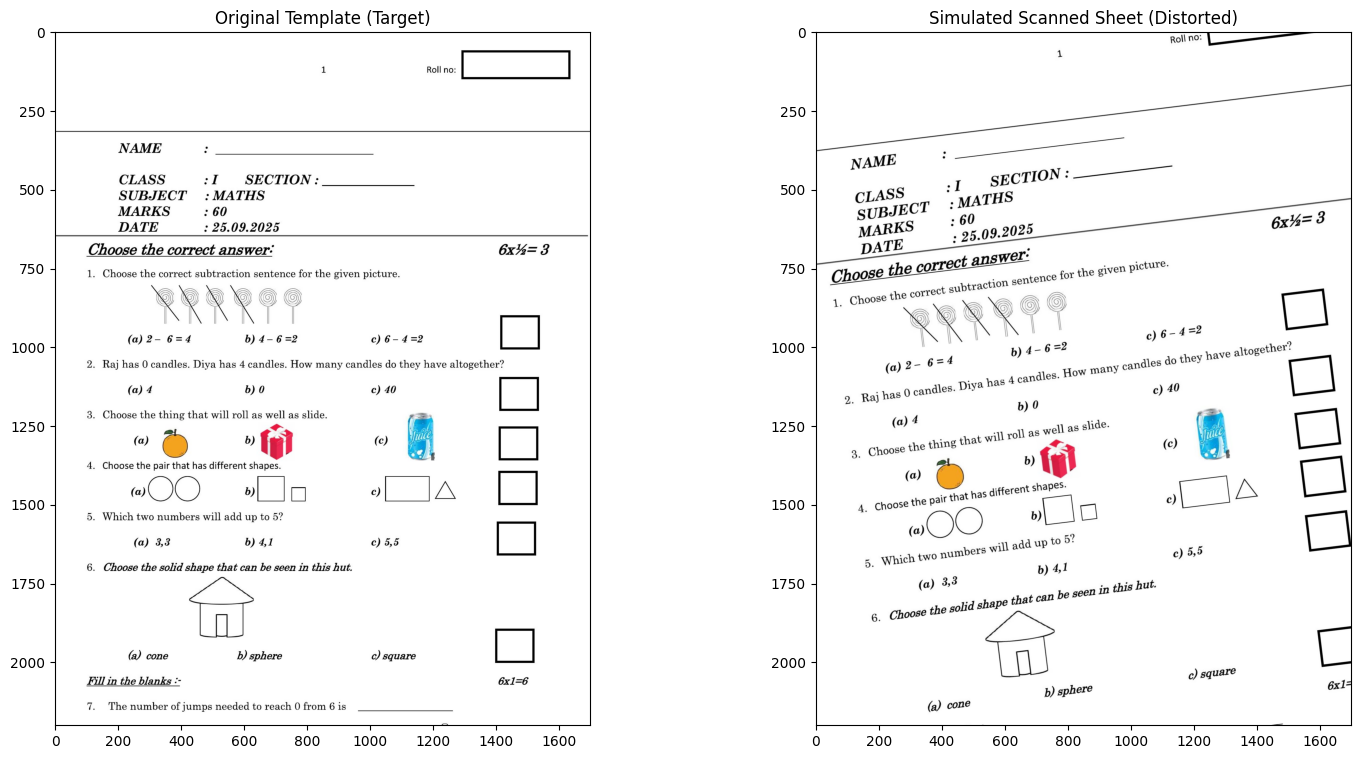

In [ ]:
# Load the template image
template_img = cv2.imread('1.jpg')
if template_img is None:
    print("Error: Could not load 1.jpg. Please ensure the file is uploaded to Colab.")
    # Stop execution or use a dummy image if file loading fails
    # ...

height, width = template_img.shape[:2]
center = (width // 2, height // 2)

# SIMULATION: Rotation (Skewness), Scaling (Scale Variations), and Translation
angle = 7 # 7 degree rotation (within the +/- 15 degree range) [cite: 14]
scale = 1.08 # 8% scale variation (within the +/- 10% range) [cite: 16]
translation_x = 50 # 50 pixel X translation (Translation Shifts) [cite: 17]

# 1. Rotation and Scaling Matrix
M_rot = cv2.getRotationMatrix2D(center, angle, scale)
# 2. Add Translation
M_rot[0, 2] += translation_x
M_rot[1, 2] += 20 # Small vertical shift

# Apply distortion
simulated_distorted_img = cv2.warpAffine(template_img, M_rot, (width, height), borderMode=cv2.BORDER_REPLICATE)

print("--- Distorted Sheet Simulation Complete ---")
display_images(template_img, "Original Template (Target)", simulated_distorted_img, "Simulated Scanned Sheet (Distorted)")

In [ ]:
# --- Preprocessing (Addressing Noise/Contrast Variations) ---
template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
distorted_gray = cv2.cvtColor(simulated_distorted_img, cv2.COLOR_BGR2GRAY)

# Adaptive Thresholding is better for different lighting (Contrast/Brightness Variations) [cite: 22]
template_thresh = cv2.adaptiveThreshold(template_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV, 11, 2)
distorted_thresh = cv2.adaptiveThreshold(distorted_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                         cv2.THRESH_BINARY_INV, 11, 2)

# --- Feature Matching and Homography ---
# 1. Initialize ORB Feature Detector
orb = cv2.ORB_create(nfeatures=5000)

# 2. Find keypoints and descriptors
kp_template, des_template = orb.detectAndCompute(template_thresh, None)
kp_distorted, des_distorted = orb.detectAndCompute(distorted_thresh, None)

# Check if descriptors were found
if des_template is None or des_distorted is None:
    print("Error: Could not find sufficient features for alignment.")
    # ... handle error ...

# 3. Match the features (Brute-Force Matcher)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_template, des_distorted)
matches = sorted(matches, key=lambda x: x.distance)[:300] # Use top 300 matches

# 4. Extract location of keypoints
src_pts = np.float32([kp_template[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_distorted[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

# 5. Find the Homography matrix (M) for perspective transformation
M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# Store the transformation parameters
transformation_parameters = M

--- Alignment Applied ---


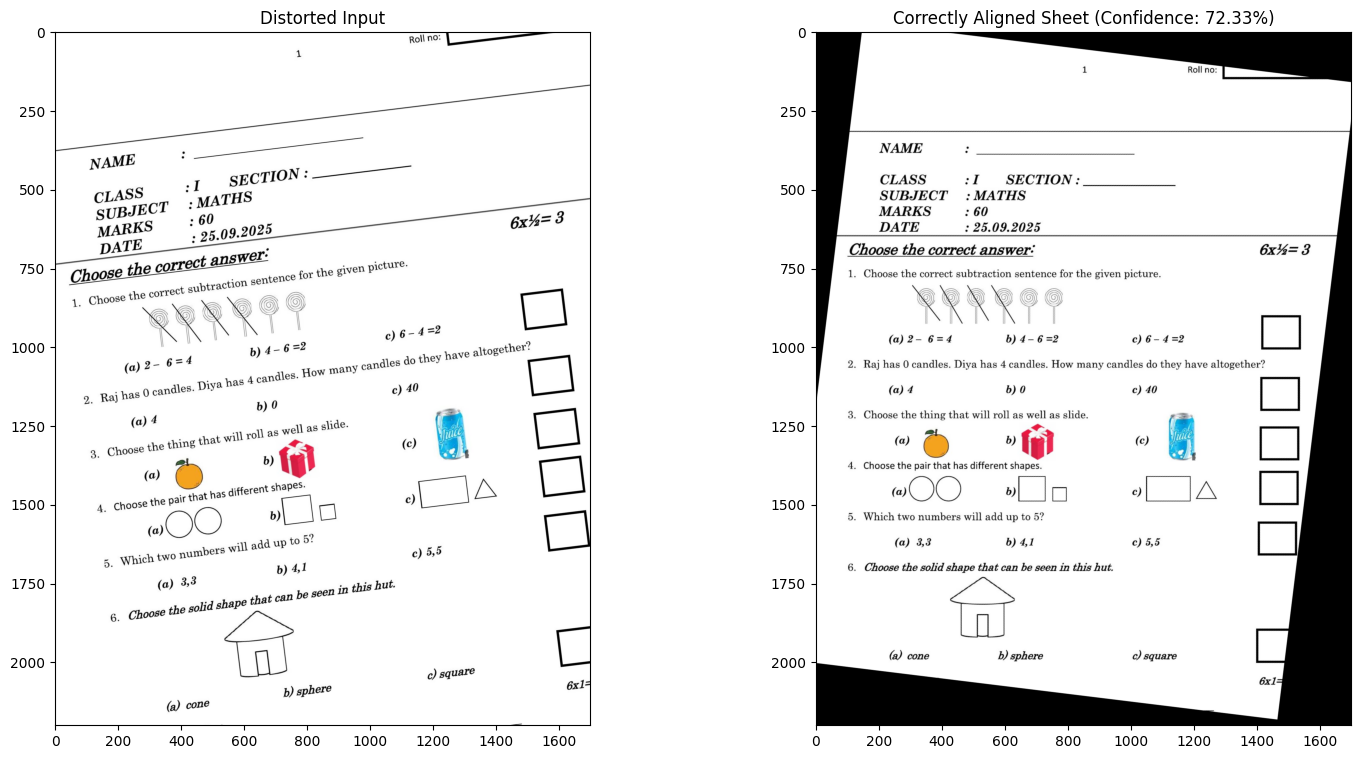


--- Phase 1: Alignment Output ---
Transformation Parameters (Homography Matrix):
 [[ 9.19357845e-01 -1.12832181e-01  1.49131954e+02]
 [ 1.12915159e-01  9.19364046e-01 -3.10810004e+01]
 [ 6.35607510e-08  1.17754487e-07  1.00000000e+00]]
Alignment Confidence Score: 72.33%
Correctly Aligned Answer Sheet Image: [Displayed Above]


In [ ]:
# 6. Apply the transformation (align the distorted image)
aligned_sheet = cv2.warpPerspective(simulated_distorted_img, M, (width, height))

# 7. Calculate Alignment confidence score (RANSAC Inlier Ratio)
if mask is not None:
    # --- FIX ---
    # inlier_ratio is a scalar (a single number), so we remove the [0] index.
    inlier_ratio = np.sum(mask) / len(mask)
    alignment_confidence = f"{inlier_ratio*100:.2f}%"
else:
    alignment_confidence = "0.00% (Alignment Failed)"

# Display the aligned result
print("--- Alignment Applied ---")
display_images(simulated_distorted_img, "Distorted Input", aligned_sheet, f"Correctly Aligned Sheet (Confidence: {alignment_confidence})")

print("\n--- Phase 1: Alignment Output ---")
# transformation_parameters was 'M' from the previous step
print("Transformation Parameters (Homography Matrix):\n", transformation_parameters)
print("Alignment Confidence Score:", alignment_confidence)
print("Correctly Aligned Answer Sheet Image: [Displayed Above]")

Successfully loaded blank template '1.jpg' and student sheet '1_marked.jpg'


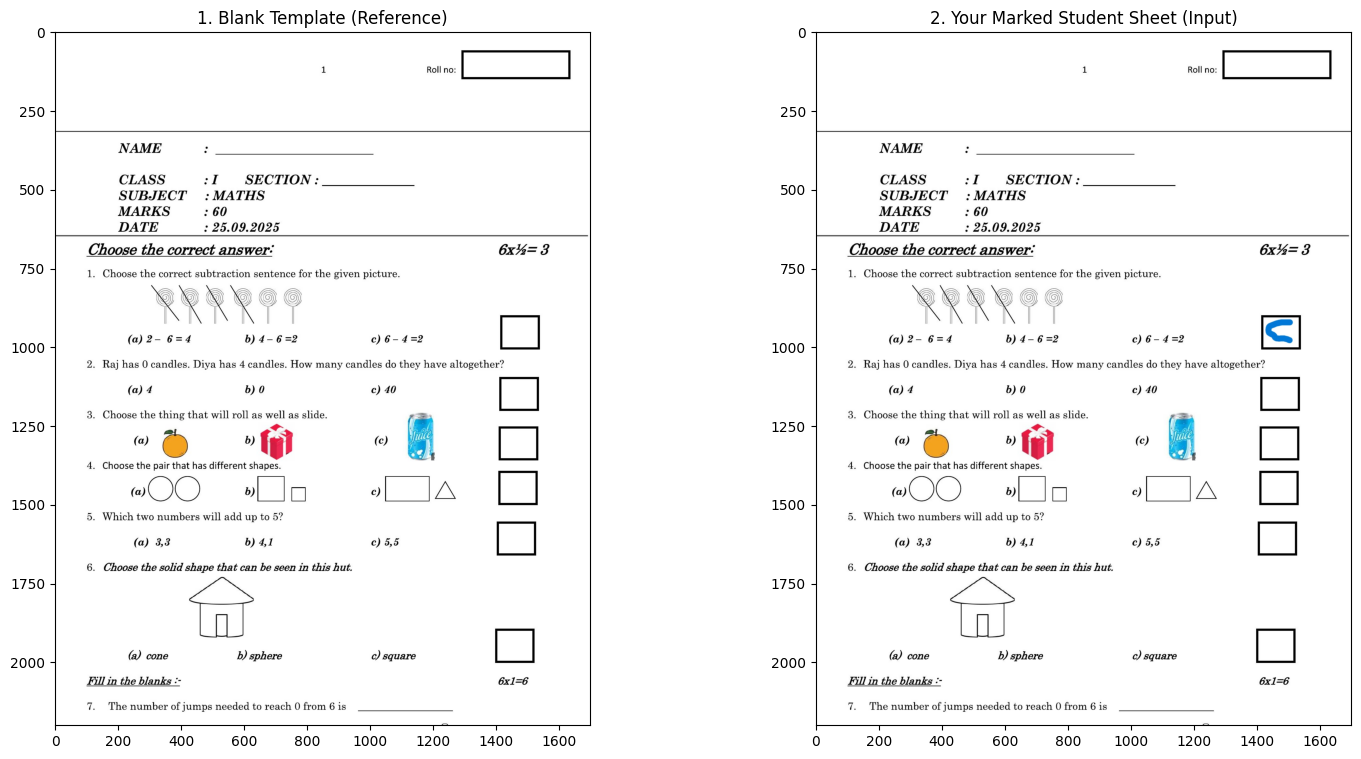

--- Distortion applied to your MARKED sheet ---


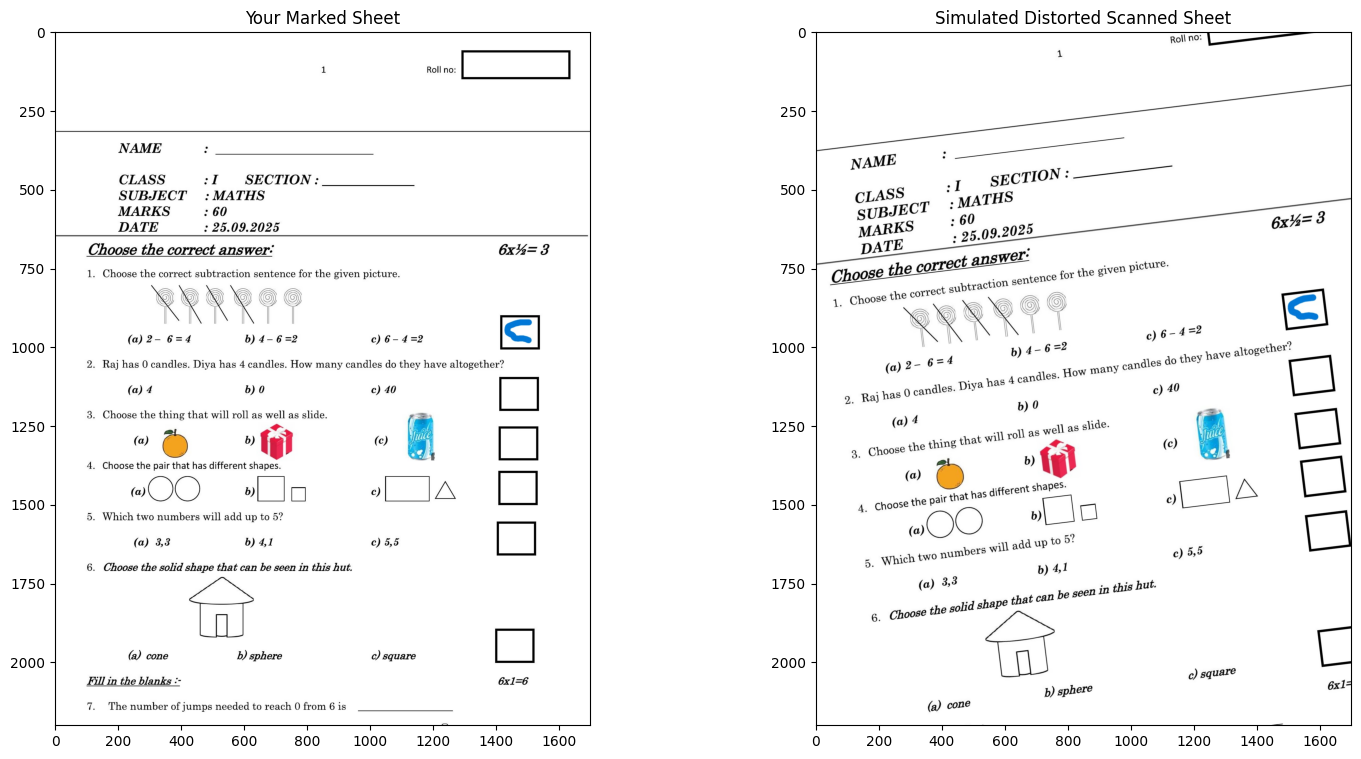

--- Alignment calculation complete for MARKED sheet ---
--- Alignment Applied ---


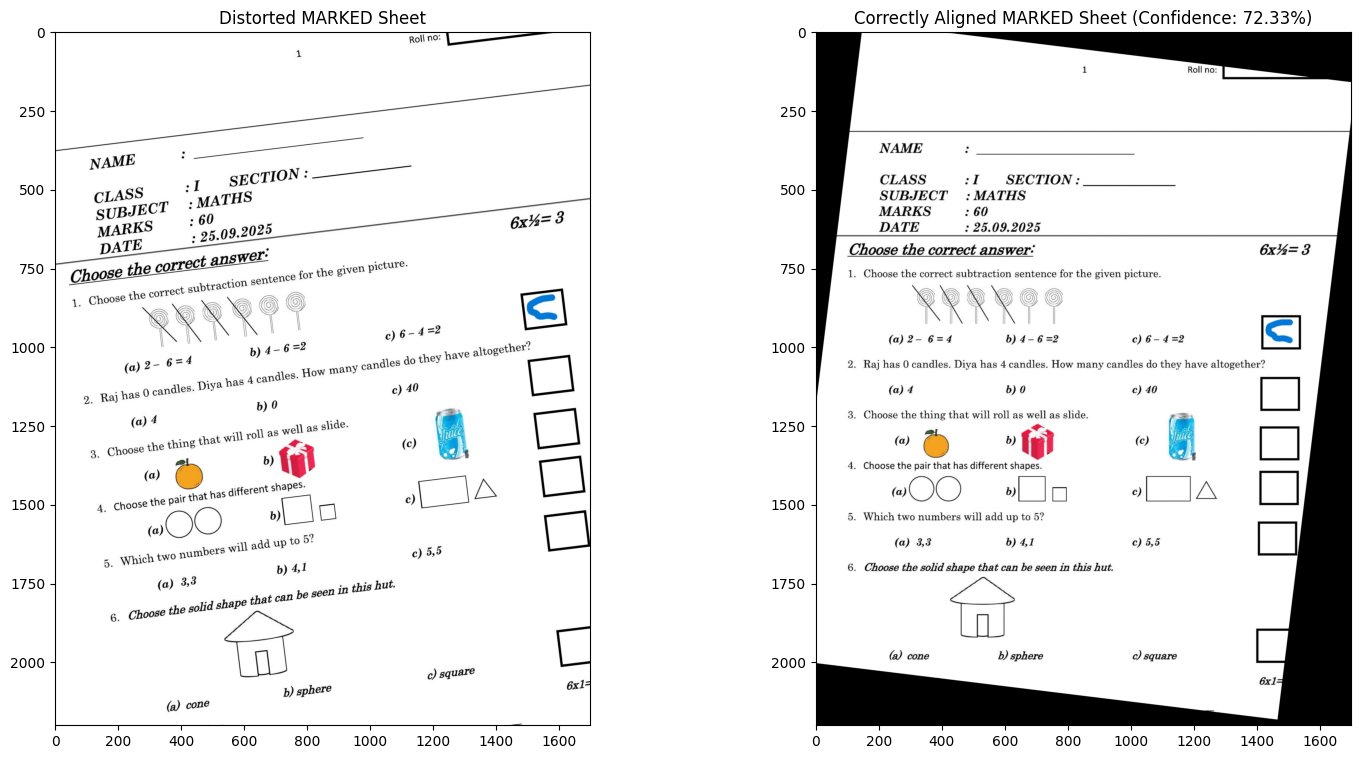

Alignment Confidence Score: 72.33%

--- Phase 1 (Test Run) Complete. The 'aligned_sheet' variable is now updated with your marked image. ---


In [ ]:
# --- Phase 1 (Modified): Aligning MARKED Sheet to BLANK Template ---

# --- 1. Load BOTH images ---
template_img = cv2.imread('1.jpg')
if template_img is None:
    print("Error: Could not load BLANK template '1.jpg'. Please upload it.")

# --- IMPORTANT ---
# Change this filename to whatever you named your marked image
student_sheet_path = '1_marked.jpg'
# --- IMPORTANT ---

student_img = cv2.imread(student_sheet_path)
if student_img is None:
    print(f"Error: Could not load your marked sheet '{student_sheet_path}'. Please upload it and check the name.")
else:
    print(f"Successfully loaded blank template '1.jpg' and student sheet '{student_sheet_path}'")
    display_images(template_img, "1. Blank Template (Reference)", student_img, "2. Your Marked Student Sheet (Input)")

# --- 2. Simulate Distortion on the STUDENT sheet ---
height, width = student_img.shape[:2]
center = (width // 2, height // 2)

# Using the same distortions as before
angle = 7
scale = 1.08
translation_x = 50
M_rot = cv2.getRotationMatrix2D(center, angle, scale)
M_rot[0, 2] += translation_x
M_rot[1, 2] += 20

# This is the 'scanned' sheet, complete with marks AND distortion
simulated_distorted_img = cv2.warpAffine(student_img, M_rot, (width, height), borderMode=cv2.BORDER_REPLICATE)
print("--- Distortion applied to your MARKED sheet ---")
display_images(student_img, "Your Marked Sheet", simulated_distorted_img, "Simulated Distorted Scanned Sheet")


# --- 3. Preprocessing and Feature Matching ---
# We align the distorted sheet (from student_img) back to the blank template (template_img)
template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
distorted_gray = cv2.cvtColor(simulated_distorted_img, cv2.COLOR_BGR2GRAY)

template_thresh = cv2.adaptiveThreshold(template_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
distorted_thresh = cv2.adaptiveThreshold(distorted_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

orb = cv2.ORB_create(nfeatures=5000)

kp_template, des_template = orb.detectAndCompute(template_thresh, None)
kp_distorted, des_distorted = orb.detectAndCompute(distorted_thresh, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_template, des_distorted)
matches = sorted(matches, key=lambda x: x.distance)[:300]

src_pts = np.float32([kp_template[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_distorted[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
transformation_parameters = M
print("--- Alignment calculation complete for MARKED sheet ---")


# --- 4. Apply Alignment (Step 1.3 logic) ---
# This 'aligned_sheet' variable will now contain your MARKED and ALIGNED image
aligned_sheet = cv2.warpPerspective(simulated_distorted_img, M, (width, height))

if mask is not None:
    inlier_ratio = np.sum(mask) / len(mask)
    alignment_confidence = f"{inlier_ratio*100:.2f}%"
else:
    alignment_confidence = "0.00% (Alignment Failed)"

print("--- Alignment Applied ---")
display_images(simulated_distorted_img, "Distorted MARKED Sheet", aligned_sheet, f"Correctly Aligned MARKED Sheet (Confidence: {alignment_confidence})")
print("Alignment Confidence Score:", alignment_confidence)
print("\n--- Phase 1 (Test Run) Complete. The 'aligned_sheet' variable is now updated with your marked image. ---")

--- Phase 2.1: Evaluation Q1 (MCQ/HWR) ---


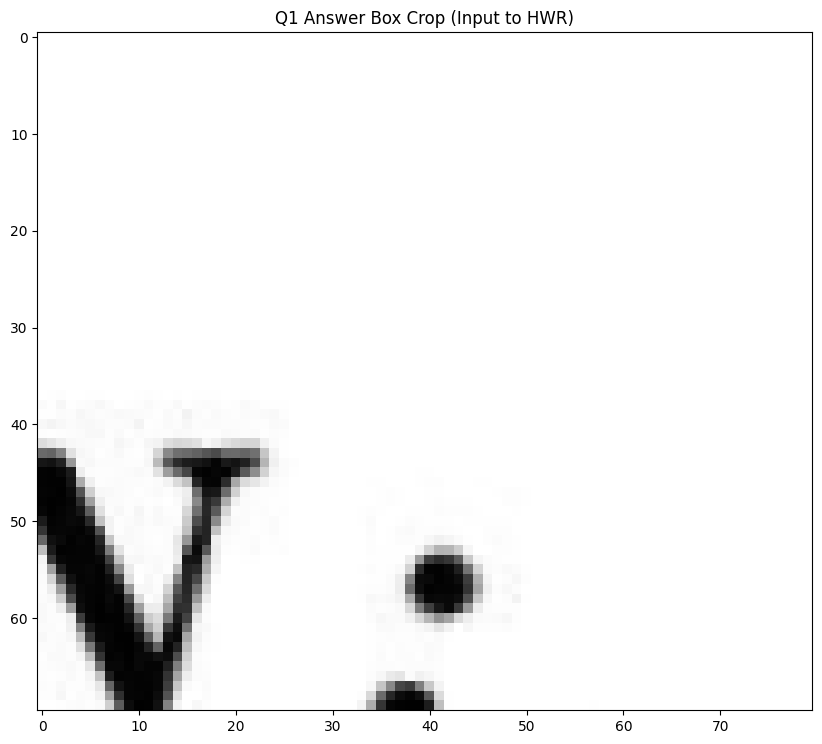

HWR Detection Raw Results: []
Reference Answer: C
Detected Answer (Cleaned): ''
Evaluation: Unanswered (HWR could not read a mark)
Score: 0 / 0.5


In [ ]:
# --- Phase 2.1: MCQ Evaluation (HWR Agent - Corrected) ---
# We are now reading the handwritten 'C', so this is an HWR/OCR task.

REFERENCE_ANSWER_Q1 = 'C' # (c) 6 - 4 = 2
MARKS_PER_MCQ = 0.5

# --- Define Region of Interest (ROI) for Q1 Answer Box ---
# We will slightly widen the ROI to ensure we capture the 'C'
# even if the alignment isn't 100% perfect.
# Original was: (800, 420, 860, 470)
q1_box_roi = (790, 410, 870, 480) # (x_start, y_start, x_end, y_end)

# Extract the ROI from the ALIGNED sheet (which has your 'C' on it)
q1_box_crop = aligned_sheet[q1_box_roi[1]:q1_box_roi[3], q1_box_roi[0]:q1_box_roi[2]]

# --- HWR Logic: Read the mark using EasyOCR ---
# We use the 'reader' we initialized in Phase 0.
# We add an 'allowlist' to force it to look only for 'a', 'b', or 'c'.
# This dramatically improves accuracy for MCQs.
try:
    results = reader.readtext(q1_box_crop, allowlist='abcABC')
except Exception as e:
    print(f"Error during EasyOCR readtext: {e}")
    results = [] # Treat as no result

q1_score = 0
q1_evaluation = "Unanswered"
detected_text = "" # This will hold the text we read

if results:
    # 'results' is a list, e.g., [([box_coords], 'C', confidence_score)]
    # We take the text from the first result [0][1]
    detected_text = results[0][1].strip().upper() # Clean it up (e.g., " c " -> "C")

    if detected_text == REFERENCE_ANSWER_Q1:
        q1_score = MARKS_PER_MCQ
        q1_evaluation = "Correct"
    else:
        q1_score = 0
        q1_evaluation = f"Incorrect (Detected: '{detected_text}')"

else:
    # This means EasyOCR couldn't find any text in the box
    q1_evaluation = "Unanswered (HWR could not read a mark)"

# --- Display HWR Results ---
print(f"--- Phase 2.1: Evaluation Q1 (MCQ/HWR) ---")
display_images(q1_box_crop, "Q1 Answer Box Crop (Input to HWR)")

print(f"HWR Detection Raw Results: {results}")
print(f"Reference Answer: {REFERENCE_ANSWER_Q1}")
print(f"Detected Answer (Cleaned): '{detected_text}'")
print(f"Evaluation: {q1_evaluation}")
print(f"Score: {q1_score} / {MARKS_PER_MCQ}")

--- Debug: Visualizing the Answer Box We Are Trying to Read ---
Drawing a red box at: (790, 410, 870, 480)


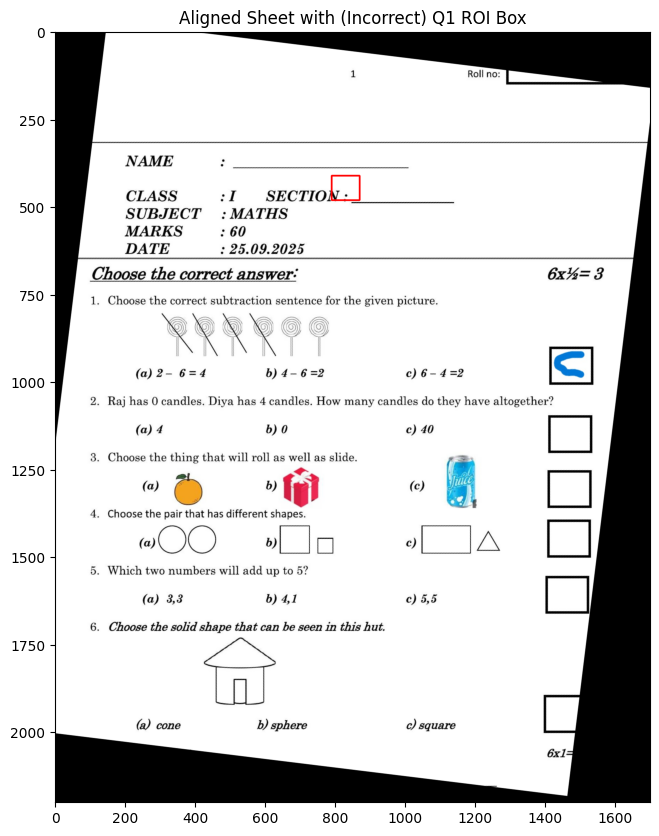

In [ ]:
# --- Debug Step: Visualize the ROI ---

# These are the (INCORRECT) coordinates we just used
q1_box_roi = (790, 410, 870, 480) # (x_start, y_start, x_end, y_end)

# Create a copy of the aligned sheet to draw on
# 'aligned_sheet' is still in memory from the last step
debug_img = aligned_sheet.copy()

# Draw a red rectangle (BGR color: 0, 0, 255)
# cv2.rectangle(image, (x_start, y_start), (x_end, y_end), (color), thickness)
cv2.rectangle(debug_img,
              (q1_box_roi[0], q1_box_roi[1]),
              (q1_box_roi[2], q1_box_roi[3]),
              (0, 0, 255),  # Red color
              3)            # 3 pixel thickness

# Display the image
print("--- Debug: Visualizing the Answer Box We Are Trying to Read ---")
print(f"Drawing a red box at: {q1_box_roi}")
display_images(debug_img, "Aligned Sheet with (Incorrect) Q1 ROI Box")

--- Interactive Coordinate Finder ---
1. Run this cell.
2. A plot of your 'aligned_sheet' will appear.
3. HOVER your mouse over the Q1 answer box.
4. The (x, y) coordinates will update live below the image.
5. Note down the (x_start, y_start) [TOP-LEFT] and (x_end, y_end) [BOTTOM-RIGHT] corners.


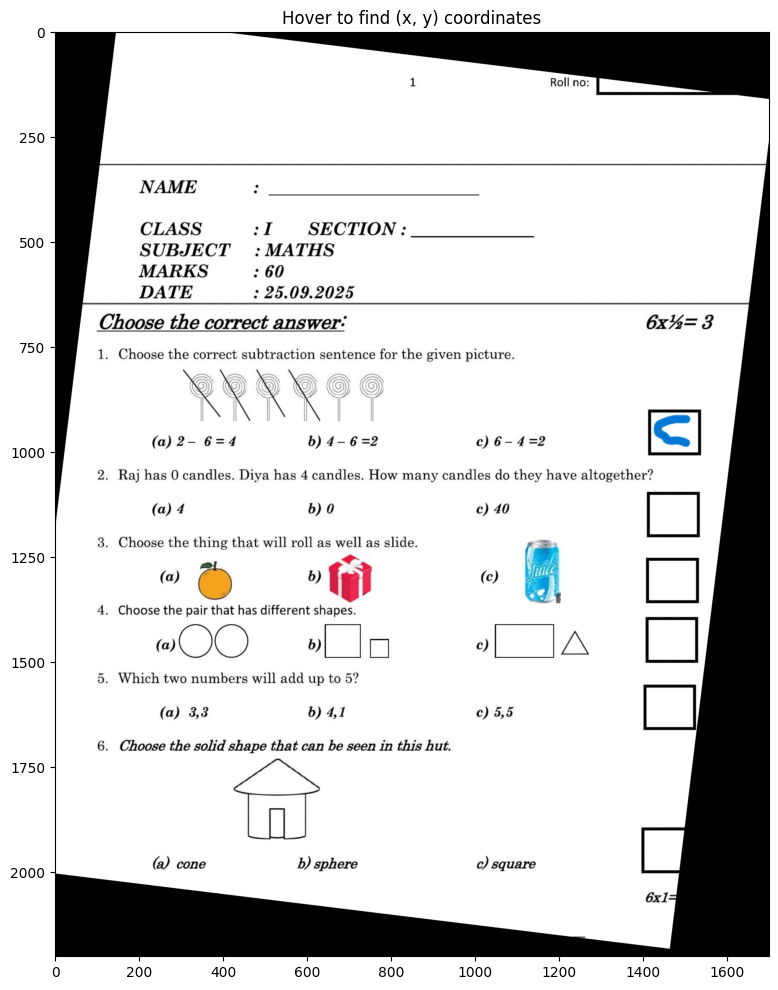

In [ ]:
# --- Interactive Debug Step: Find Correct Coordinates ---

# We will use 'aligned_sheet' which is still in memory and has your marks
img_to_find = aligned_sheet.copy()

# Plot the image using Matplotlib, which has an interactive backend
print("--- Interactive Coordinate Finder ---")
print("1. Run this cell.")
print("2. A plot of your 'aligned_sheet' will appear.")
print("3. HOVER your mouse over the Q1 answer box.")
print("4. The (x, y) coordinates will update live below the image.")
print("5. Note down the (x_start, y_start) [TOP-LEFT] and (x_end, y_end) [BOTTOM-RIGHT] corners.")

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(img_to_find, cv2.COLOR_BGR2RGB))
ax.set_title("Hover to find (x, y) coordinates")

# This function updates the (x, y) display on mouse move
def format_coord(x, y):
    return f'x={x:1.0f}, y={y:1.0f}'

ax.format_coord = format_coord
plt.show()

In [ ]:
# --- Step 2.0 (Corrected): Create the "Template Map" for Q1 ---

# We load the ORIGINAL BLANK template, not the aligned sheet
# This is our "master key"
template_img_for_coords = cv2.imread('1.jpg')

# Plot the image using Matplotlib
print("--- One-Time Setup: Finding Coordinates on BLANK Template ---")
print("1. Run this cell.")
print("2. A plot of the ORIGINAL '1.jpg' will appear.")
print("3. HOVER your mouse over the Q1 answer box.")
print("4. Note the (x_start, y_start) [TOP-LEFT] and (x_end, y_end) [BOTTOM-RIGHT] corners.")

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(cv2.cvtColor(template_img_for_coords, cv2.COLOR_BGR2RGB))
ax.set_title("Hover on ORIGINAL 1.jpg to find Q1 Box Coordinates")

# This function updates the (x, y) display on mouse move
def format_coord(x, y):
    return f'x={x:1.0f}, y={y:1.0f}'

ax.format_coord = format_coord
plt.show()

--- One-Time Setup: Finding Coordinates on BLANK Template ---
1. Run this cell.
2. A plot of the ORIGINAL '1.jpg' will appear.
3. HOVER your mouse over the Q1 answer box.
4. Note the (x_start, y_start) [TOP-LEFT] and (x_end, y_end) [BOTTOM-RIGHT] corners.


In [ ]:
# --- Step 2.0 (Automated): Find All Answer Boxes on BLANK Template ---

# We load the ORIGINAL BLANK template
template_img = cv2.imread('1.jpg')
if template_img is None:
    print("Error: Could not load 1.jpg")
else:
    print("Loaded 1.jpg to find answer boxes...")

# 1. Preprocessing
gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
# We apply an inverse binary threshold. This makes the box borders white (255)
# and everything else black (0).
_, thresh = cv2.threshold(gray, 230, 255, cv2.THRESH_BINARY_INV)

# 2. Find Contours (shapes)
# cv2.RETR_EXTERNAL finds only the outermost shapes (our boxes)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

template_with_boxes = template_img.copy() # Create a copy to draw on
template_map = {} # This will store our coordinates

box_count = 0
for cnt in contours:
    # 3. Filter Contours
    x, y, w, h = cv2.boundingRect(cnt)

    # We filter by size and aspect ratio to find only the "answer boxes"
    # and ignore random specks or the page border.
    # We want boxes that are roughly square and of a reasonable size.
    aspect_ratio = w / float(h)

    # --- Tunable Parameters ---
    # These values are tuned for our specific sheet.
    # We are looking for boxes that are (approx) 40px to 100px wide
    # and have an aspect ratio close to 1 (a square).
    if w > 40 and w < 100 and aspect_ratio > 0.8 and aspect_ratio < 1.2:

        # We found a box!
        box_count += 1

        # Store its coordinates. We add a 5-pixel "padding" to make sure
        # we capture the whole handwritten answer, not just the box lines.
        roi = (x - 5, y - 5, x + w + 5, y + h + 5) # (x_start, y_start, x_end, y_end)

        # Store it. We use the 'y' coordinate as the key, so they are sorted by
        # their vertical position on the page (Q1, then Q2, etc.)
        template_map[y] = roi

        # Draw a GREEN rectangle on our visual copy
        cv2.rectangle(template_with_boxes, (roi[0], roi[1]), (roi[2], roi[3]), (0, 255, 0), 3)

# 4. Finalize the Template Map
# Sort the map by the 'y' coordinate (key) to get boxes in top-to-bottom order
sorted_keys = sorted(template_map.keys())
final_template_map = [template_map[key] for key in sorted_keys]

# Display the result
print(f"\n--- Automated Template Analysis Complete ---")
print(f"Found {len(final_template_map)} answer boxes.")
print("Displaying detected boxes on the template...")
display_images(template_with_boxes, "Automatically Detected Answer Boxes")

# Print the coordinates we found.
# These are the coordinates we will use to grade ALL student sheets.
print("\n--- Generated Template Map (Coordinates) ---")
for i, roi in enumerate(final_template_map):
    print(f"Box {i+1}: {roi}")

# We will save the Q1 box (the first one) for the next step
# This 'q1_box_roi' is now AUTOMATICALLY generated.
q1_box_roi = final_template_map[0]
print(f"\nUsing Q1 Box ROI: {q1_box_roi} for the next step.")

Loaded 1.jpg to find answer boxes...

--- Automated Template Analysis Complete ---
Found 5 answer boxes.
Displaying detected boxes on the template...



--- Generated Template Map (Coordinates) ---
Box 1: (336, 1254, 427, 1357)
Box 2: (290, 1404, 381, 1495)
Box 3: (637, 1405, 733, 1495)
Box 4: (1199, 1420, 1277, 1488)
Box 5: (745, 1440, 800, 1495)

Using Q1 Box ROI: (336, 1254, 427, 1357) for the next step.


In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import easyocr
import os


--- Running Robust Shape Analysis ---

Found 7 answer boxes using Shape Analysis.


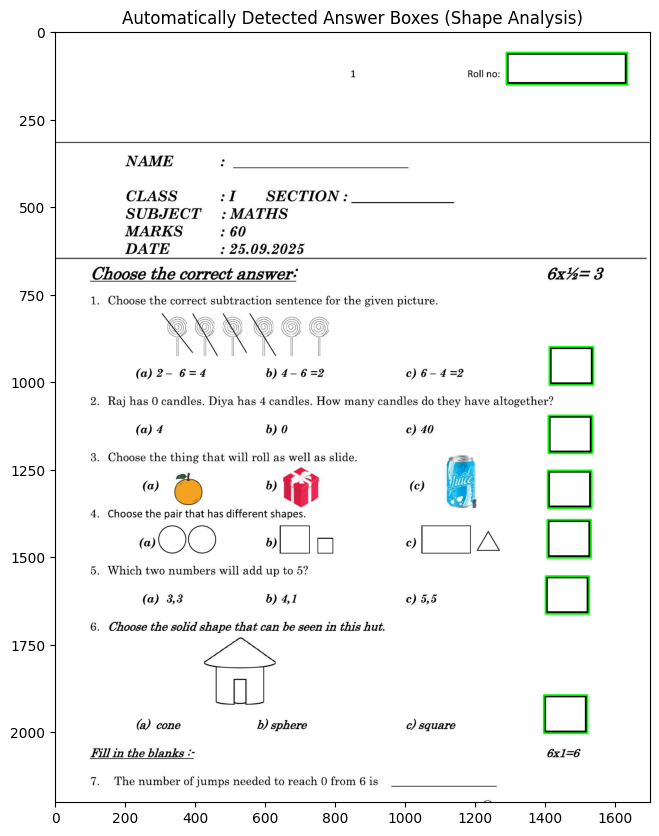


--- Generated Template Map (Coordinates) ---
Box 1 (y-coord: 58): (1284, 53, 1640, 155)
Box 2 (y-coord: 899): (1407, 894, 1543, 1013)
Box 3 (y-coord: 1095): (1404, 1090, 1540, 1208)
Box 4 (y-coord: 1252): (1402, 1247, 1538, 1365)
Box 5 (y-coord: 1393): (1401, 1388, 1536, 1507)
Box 6 (y-coord: 1554): (1396, 1549, 1531, 1667)
Box 7 (y-coord: 1894): (1391, 1889, 1526, 2008)

Successfully isolated Q1 Box ROI: (1284, 53, 1640, 155)


In [ ]:
# --- Step 2.0 (Robust): Find Boxes via Shape Analysis ---

template_img = cv2.imread('1.jpg')
gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)

# 1. Preprocessing (Blur slightly to remove noise)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# Use adaptive thresholding to handle lighting differences
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# 2. Find ALL Contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

template_with_boxes = template_img.copy()
template_map = {}

print("--- Running Robust Shape Analysis ---")

for cnt in contours:
    # 3. Analyze the Shape (Approximate the polygon)
    perimeter = cv2.arcLength(cnt, True)
    # The '0.02 * perimeter' is the precision. It's a standard value.
    approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)

    # 4. Filter for Rectangles (which have 4 vertices)
    if len(approx) == 4:
        # We found a 4-sided polygon (a rectangle or square)
        x, y, w, h = cv2.boundingRect(cnt)

        # 5. Filter by Location (A simple, robust filter)
        # Only keep rectangles that are on the right-hand third of the page.
        if x > (template_img.shape[1] / 3) * 2: # x > (page_width / 3) * 2

            # 6. Filter by Size (to ignore tiny specks)
            if w > 50 and h > 20:
                # --- We found an answer box! ---
                roi = (x - 5, y - 5, x + w + 5, y + h + 5) # Add padding
                template_map[y] = roi # Use 'y' to sort

                # Draw a GREEN box to confirm
                cv2.rectangle(template_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 3)

# --- 6. Finalize and Display ---
sorted_keys = sorted(template_map.keys())
final_template_map = [template_map[key] for key in sorted_keys]

print(f"\nFound {len(final_template_map)} answer boxes using Shape Analysis.")
display_images(template_with_boxes, "Automatically Detected Answer Boxes (Shape Analysis)")

if final_template_map:
    print("\n--- Generated Template Map (Coordinates) ---")
    for i, roi in enumerate(final_template_map):
        print(f"Box {i+1} (y-coord: {sorted_keys[i]}): {roi}")

    # Save the Q1 box (the first one) for the next step
    q1_box_roi = final_template_map[0]
    print(f"\nSuccessfully isolated Q1 Box ROI: {q1_box_roi}")
else:
    print("Error: No answer boxes were found. The filter logic may need tuning.")
    q1_box_roi = None

--- Running Robust Shape Analysis ---

Found 7 answer boxes using Shape Analysis.


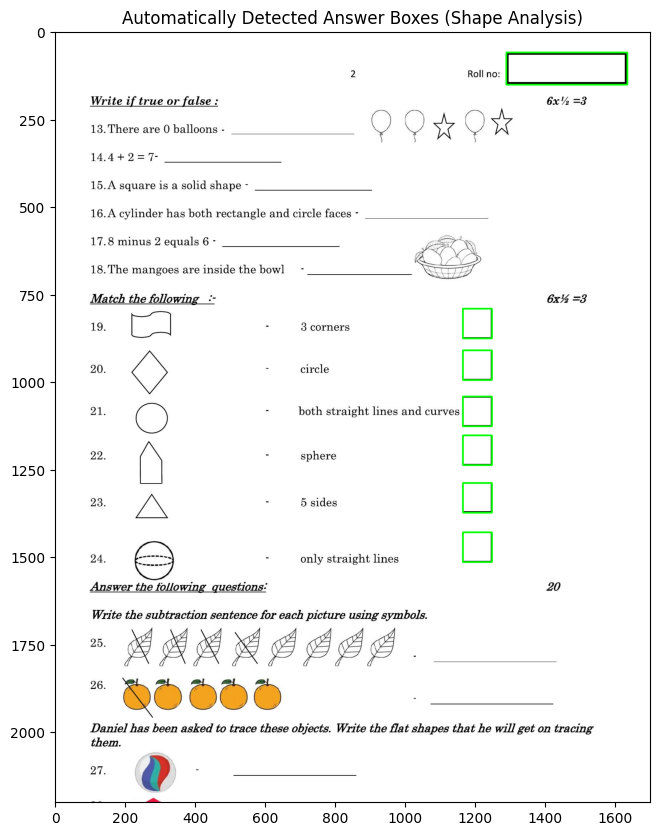


--- Generated Template Map (Coordinates) ---
Box 1 (y-coord: 58): (1284, 53, 1640, 155)
Box 2 (y-coord: 790): (1160, 785, 1253, 880)
Box 3 (y-coord: 909): (1160, 904, 1253, 999)
Box 4 (y-coord: 1041): (1160, 1036, 1253, 1131)
Box 5 (y-coord: 1152): (1160, 1147, 1253, 1242)
Box 6 (y-coord: 1288): (1160, 1283, 1253, 1378)
Box 7 (y-coord: 1429): (1160, 1424, 1253, 1519)

Successfully isolated Q1 Box ROI: (1284, 53, 1640, 155)


In [ ]:
# --- Step 2.0 (Robust): Find Boxes via Shape Analysis ---

template_img = cv2.imread('2.jpg')
gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)

# 1. Preprocessing (Blur slightly to remove noise)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
# Use adaptive thresholding to handle lighting differences
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

# 2. Find ALL Contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

template_with_boxes = template_img.copy()
template_map = {}

print("--- Running Robust Shape Analysis ---")

for cnt in contours:
    # 3. Analyze the Shape (Approximate the polygon)
    perimeter = cv2.arcLength(cnt, True)
    # The '0.02 * perimeter' is the precision. It's a standard value.
    approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)

    # 4. Filter for Rectangles (which have 4 vertices)
    if len(approx) == 4:
        # We found a 4-sided polygon (a rectangle or square)
        x, y, w, h = cv2.boundingRect(cnt)

        # 5. Filter by Location (A simple, robust filter)
        # Only keep rectangles that are on the right-hand third of the page.
        if x > (template_img.shape[1] / 3) * 2: # x > (page_width / 3) * 2

            # 6. Filter by Size (to ignore tiny specks)
            if w > 50 and h > 20:
                # --- We found an answer box! ---
                roi = (x - 5, y - 5, x + w + 5, y + h + 5) # Add padding
                template_map[y] = roi # Use 'y' to sort

                # Draw a GREEN box to confirm
                cv2.rectangle(template_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 3)

# --- 6. Finalize and Display ---
sorted_keys = sorted(template_map.keys())
final_template_map = [template_map[key] for key in sorted_keys]

print(f"\nFound {len(final_template_map)} answer boxes using Shape Analysis.")
display_images(template_with_boxes, "Automatically Detected Answer Boxes (Shape Analysis)")

if final_template_map:
    print("\n--- Generated Template Map (Coordinates) ---")
    for i, roi in enumerate(final_template_map):
        print(f"Box {i+1} (y-coord: {sorted_keys[i]}): {roi}")

    # Save the Q1 box (the first one) for the next step
    q1_box_roi = final_template_map[0]
    print(f"\nSuccessfully isolated Q1 Box ROI: {q1_box_roi}")
else:
    print("Error: No answer boxes were found. The filter logic may need tuning.")
    q1_box_roi = None

--- Running Smarter Shape Analysis (w/ Size Filter) ---

Found 7 REAL answer boxes.


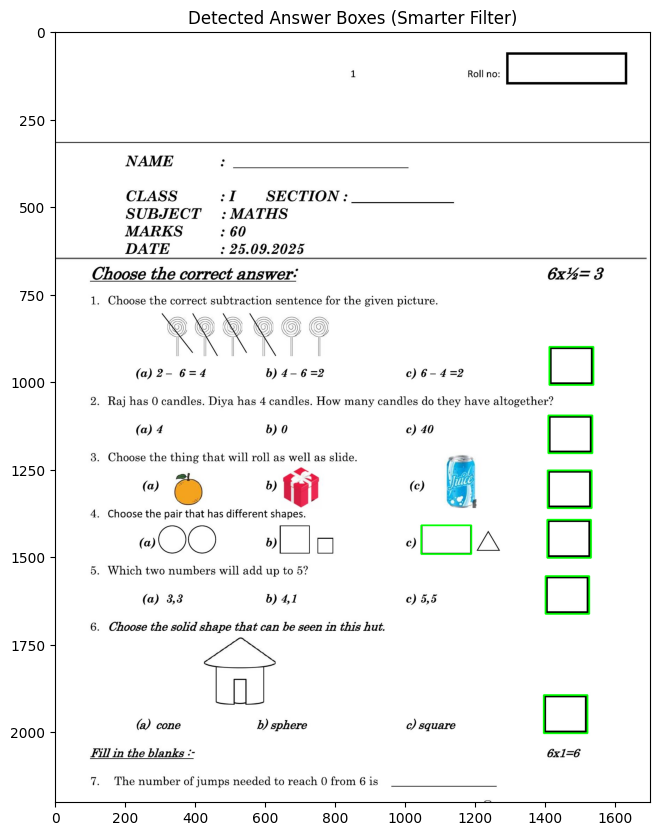


--- Generated Template Map (Page 1) ---
Question Box 1 (y-coord: 899): (1407, 894, 1543, 1013)
Question Box 2 (y-coord: 1095): (1404, 1090, 1540, 1208)
Question Box 3 (y-coord: 1252): (1402, 1247, 1538, 1365)
Question Box 4 (y-coord: 1393): (1401, 1388, 1536, 1507)
Question Box 5 (y-coord: 1409): (1041, 1404, 1194, 1496)
Question Box 6 (y-coord: 1554): (1396, 1549, 1531, 1667)
Question Box 7 (y-coord: 1894): (1391, 1889, 1526, 2008)

Successfully isolated Q1 Box ROI: (1407, 894, 1543, 1013)


In [ ]:
# --- Step 2.2: Smarter Filter for Page 1 ('1.jpg') ---

template_img = cv2.imread('1.jpg')
gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

template_with_boxes = template_img.copy()
template_map = {}

print("--- Running Smarter Shape Analysis (w/ Size Filter) ---")

for cnt in contours:
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)

    # 1. Is it a rectangle?
    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(cnt)

        # 2. Is it on the right side?
        if x > (template_img.shape[1] / 2): # x > (page_width / 2)

            # --- 3. THE NEW FILTER ---
            # Is it the right size? (IGNORE the wide "Roll no" box)
            # We only want boxes with width < 300 and height > 50
            if (w < 300 and w > 50) and (h > 50):

                # --- We found a REAL answer box! ---
                roi = (x - 5, y - 5, x + w + 5, y + h + 5) # Add padding
                template_map[y] = roi # Use 'y' to sort

                # Draw a GREEN box to confirm
                cv2.rectangle(template_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 3)

# --- 4. Finalize and Display ---
sorted_keys = sorted(template_map.keys())
final_template_map = [template_map[key] for key in sorted_keys]

print(f"\nFound {len(final_template_map)} REAL answer boxes.")
display_images(template_with_boxes, "Detected Answer Boxes (Smarter Filter)")

if final_template_map:
    print("\n--- Generated Template Map (Page 1) ---")
    # This list is now correctly sorted by question number
    for i, roi in enumerate(final_template_map):
        print(f"Question Box {i+1} (y-coord: {sorted_keys[i]}): {roi}")

    # Save the Q1 box (the first one) for the next step
    q1_box_roi = final_template_map[0]
    print(f"\nSuccessfully isolated Q1 Box ROI: {q1_box_roi}")
else:
    print("Error: No answer boxes were found.")
    q1_box_roi = None

In [ ]:
# --- Step 2.3: Tighter Location Filter for Page 1 ('1.jpg') ---

template_img = cv2.imread('1.jpg')
gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

template_with_boxes = template_img.copy()
template_map = {}
page_width = template_img.shape[1]

print("--- Running Tighter Filter (x > 70% of page) ---")

for cnt in contours:
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)

    if len(approx) == 4: # Is it a rectangle?
        x, y, w, h = cv2.boundingRect(cnt)

        # --- 1. THE NEW FILTER ---
        # Only look at the far-right 30% of the page
        if x > (page_width * 0.7):

            # --- 2. OLD FILTERS (still apply) ---
            if (w < 300 and w > 50) and (h > 50):

                roi = (x - 5, y - 5, x + w + 5, y + h + 5)
                template_map[y] = roi
                cv2.rectangle(template_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 3)

# --- 4. Finalize and Display ---
sorted_keys = sorted(template_map.keys())
final_template_map = [template_map[key] for key in sorted_keys]

print(f"\nFound {len(final_template_map)} REAL answer boxes.")
display_images(template_with_boxes, "Detected Answer Boxes (Tighter Filter)")

if final_template_map:
    print("\n--- Generated Template Map (Page 1) ---")
    for i, roi in enumerate(final_template_map):
        print(f"Question Box {i+1} (y-coord: {sorted_keys[i]}): {roi}")

    q1_box_roi = final_template_map[0]
    print(f"\nSuccessfully isolated Q1 Box ROI: {q1_box_roi}")
else:
    print("Error: No answer boxes were found.")
    q1_box_roi = None

--- Running Tighter Filter (x > 70% of page) ---

Found 6 REAL answer boxes.



--- Generated Template Map (Page 1) ---
Question Box 1 (y-coord: 899): (1407, 894, 1543, 1013)
Question Box 2 (y-coord: 1095): (1404, 1090, 1540, 1208)
Question Box 3 (y-coord: 1252): (1402, 1247, 1538, 1365)
Question Box 4 (y-coord: 1393): (1401, 1388, 1536, 1507)
Question Box 5 (y-coord: 1554): (1396, 1549, 1531, 1667)
Question Box 6 (y-coord: 1894): (1391, 1889, 1526, 2008)

Successfully isolated Q1 Box ROI: (1407, 894, 1543, 1013)


In [ ]:
# --- Step 1: Define the Template Map and Answer Key ---

# These are the 6 coordinates our script just successfully found
# (from your output log)
final_template_map = [
    (1407, 894, 1543, 1013), # Q1
    (1404, 1090, 1540, 1208), # Q2
    (1402, 1247, 1538, 1365), # Q3
    (1401, 1388, 1536, 1507), # Q4
    (1396, 1549, 1531, 1667), # Q5
    (1391, 1889, 1526, 2008)  # Q6
]

# This is the "Reference Answer Script" for Page 1
# Q1: 6-4=2 -> (c)
# Q2: 0+4=4 -> (a)
# Q3: Can rolls and slides -> (c)
# Q4: Rectangle/Triangle are different -> (c)
# Q5: 4+1=5 -> (b)
# Q6: Roof of hut is a cone -> (a)
REFERENCE_ANSWER_KEY = ['C', 'A', 'C', 'C', 'B', 'A']

MARKS_PER_MCQ = 0.5

print(f"Loaded Template Map with {len(final_template_map)} coordinates.")
print(f"Loaded Answer Key with {len(REFERENCE_ANSWER_KEY)} answers.")

Loaded Template Map with 6 coordinates.
Loaded Answer Key with 6 answers.


Successfully loaded blank template '1.jpg' and student sheet 'answersheet1.jpg'
--- Alignment Complete (Confidence: 30.00%) ---


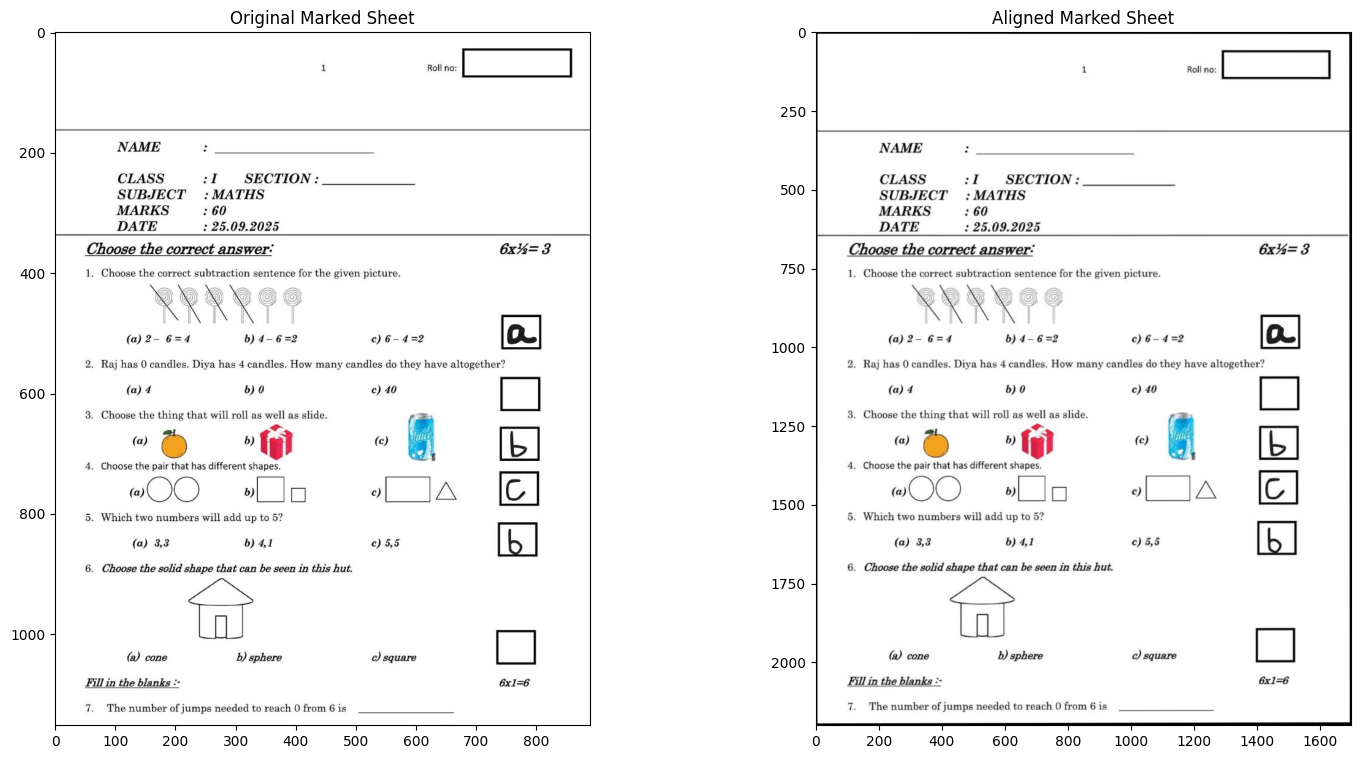

The 'aligned_sheet' variable is ready for evaluation.


In [ ]:
# --- Step 2: Align the New Student Sheet ---

# --- 1. Load BOTH images ---
template_img = cv2.imread('1.jpg')
if template_img is None:
    print("Error: Could not load BLANK template '1.jpg'. Please upload it.")

# --- IMPORTANT ---
# Change this filename if yours is different
student_sheet_path = 'answersheet1.jpg'
# --- IMPORTANT ---

student_img = cv2.imread(student_sheet_path)
if student_img is None:
    print(f"Error: Could not load your marked sheet '{student_sheet_path}'. Please upload it and check the name.")
else:
    print(f"Successfully loaded blank template '1.jpg' and student sheet '{student_sheet_path}'")

# --- 2. Preprocessing and Feature Matching ---
template_gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
distorted_gray = cv2.cvtColor(student_img, cv2.COLOR_BGR2GRAY)

template_thresh = cv2.adaptiveThreshold(template_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
distorted_thresh = cv2.adaptiveThreshold(distorted_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

orb = cv2.ORB_create(nfeatures=5000)

kp_template, des_template = orb.detectAndCompute(template_thresh, None)
kp_distorted, des_distorted = orb.detectAndCompute(distorted_thresh, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des_template, des_distorted)
matches = sorted(matches, key=lambda x: x.distance)[:300]

src_pts = np.float32([kp_template[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([kp_distorted[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

# --- 3. Apply Alignment (Step 1.3 logic) ---
height, width = template_img.shape[:2]
# This 'aligned_sheet' variable is now our MARKED and ALIGNED image
aligned_sheet = cv2.warpPerspective(student_img, M, (width, height))

inlier_ratio = np.sum(mask) / len(mask)
alignment_confidence = f"{inlier_ratio*100:.2f}%"

print(f"--- Alignment Complete (Confidence: {alignment_confidence}) ---")
display_images(student_img, "Original Marked Sheet", aligned_sheet, f"Aligned Marked Sheet")
print("The 'aligned_sheet' variable is ready for evaluation.")

--- Running Inset Filter (Cropping *inside* the boxes) ---

Found 6 REAL answer boxes.


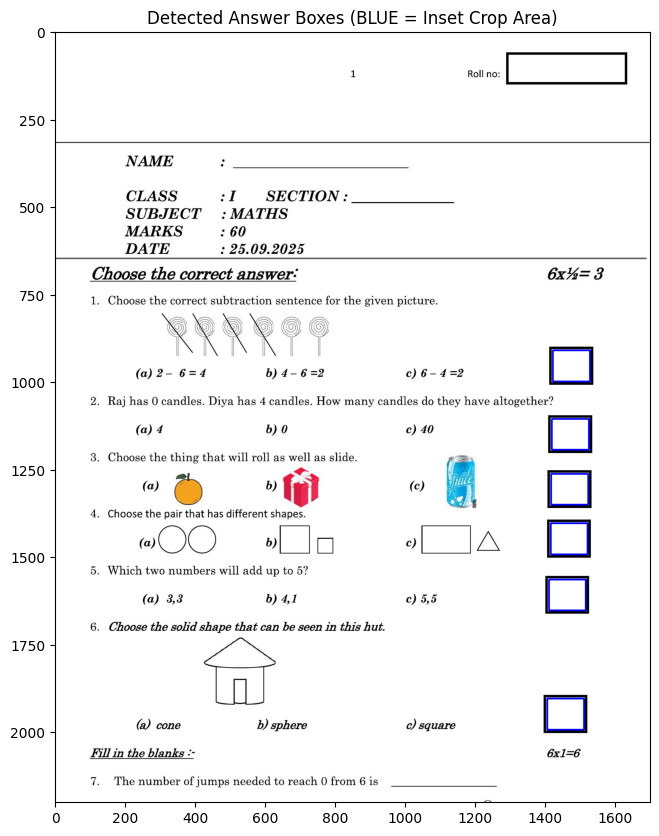


--- Generated INSET Template Map (Page 1) ---
Question Box 1 (y-coord: 899): (1422, 909, 1528, 998)
Question Box 2 (y-coord: 1095): (1419, 1105, 1525, 1193)
Question Box 3 (y-coord: 1252): (1417, 1262, 1523, 1350)
Question Box 4 (y-coord: 1393): (1416, 1403, 1521, 1492)
Question Box 5 (y-coord: 1554): (1411, 1564, 1516, 1652)
Question Box 6 (y-coord: 1894): (1406, 1904, 1511, 1993)

Successfully created new 'final_template_map_inset'. Ready for evaluation.


In [ ]:
# --- Step 1: Re-generate Template Map with INSETS ---

template_img = cv2.imread('1.jpg')
gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 11, 2)

contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

template_with_boxes = template_img.copy()
template_map = {}
page_width = template_img.shape[1]
# This is the fix: We will crop 10 pixels INSIDE the box border
inset = 10

print("--- Running Inset Filter (Cropping *inside* the boxes) ---")

for cnt in contours:
    perimeter = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, 0.02 * perimeter, True)

    if len(approx) == 4: # Is it a rectangle?
        x, y, w, h = cv2.boundingRect(cnt)

        # Far-right 30% of the page
        if x > (page_width * 0.7):
            # Correct size (not "Roll no" box)
            if (w < 300 and w > 50) and (h > 50):

                # --- THIS IS THE FIX ---
                # We create an "inset" by adding to x/y and subtracting from w/h
                roi = (x + inset, y + inset, x + w - inset, y + h - inset)
                # --- END OF FIX ---

                template_map[y] = roi # Use 'y' to sort
                # Draw a BLUE box to show the new inset crop area
                cv2.rectangle(template_with_boxes, (roi[0], roi[1]), (roi[2], roi[3]), (255, 0, 0), 3)

# --- Finalize and Display ---
sorted_keys = sorted(template_map.keys())
# We create a NEW map variable with the correct inset coordinates
final_template_map_inset = [template_map[key] for key in sorted_keys]

print(f"\nFound {len(final_template_map_inset)} REAL answer boxes.")
display_images(template_with_boxes, "Detected Answer Boxes (BLUE = Inset Crop Area)")

if final_template_map_inset:
    print("\n--- Generated INSET Template Map (Page 1) ---")
    for i, roi in enumerate(final_template_map_inset):
        print(f"Question Box {i+1} (y-coord: {sorted_keys[i]}): {roi}")

    print("\nSuccessfully created new 'final_template_map_inset'. Ready for evaluation.")
else:
    print("Error: No answer boxes were found.")

In [ ]:
# --- Step 1: Define the Template Map and Answer Key ---

# These are the 6 coordinates our script just successfully found
# (from your output log)
final_template_map = [
    (1422, 909, 1528, 998), # Q1
    (1419, 1105, 1525, 1193), # Q2
    (1417, 1262, 1523, 1350), # Q3
    (1416, 1403, 1521, 1492), # Q4
    (1411, 1564, 1516, 1652), # Q5
    (1406, 1904, 1511, 1993)  # Q6
]

# This is the "Reference Answer Script" for Page 1
# Q1: 6-4=2 -> (c)
# Q2: 0+4=4 -> (a)
# Q3: Can rolls and slides -> (c)
# Q4: Rectangle/Triangle are different -> (c)
# Q5: 4+1=5 -> (b)
# Q6: Roof of hut is a cone -> (a)
REFERENCE_ANSWER_KEY = ['C', 'A', 'C', 'C', 'B', 'A']

MARKS_PER_MCQ = 0.5

print(f"Loaded Template Map with {len(final_template_map)} coordinates.")
print(f"Loaded Answer Key with {len(REFERENCE_ANSWER_KEY)} answers.")

Loaded Template Map with 6 coordinates.
Loaded Answer Key with 6 answers.


Running EasyOCR on blank template to find Q7...
Found anchor text: 'The number of jumps needed to reach 0 from 6 is'
Generated Q7 Answer ROI: (939, 2111, 1139, 2173)


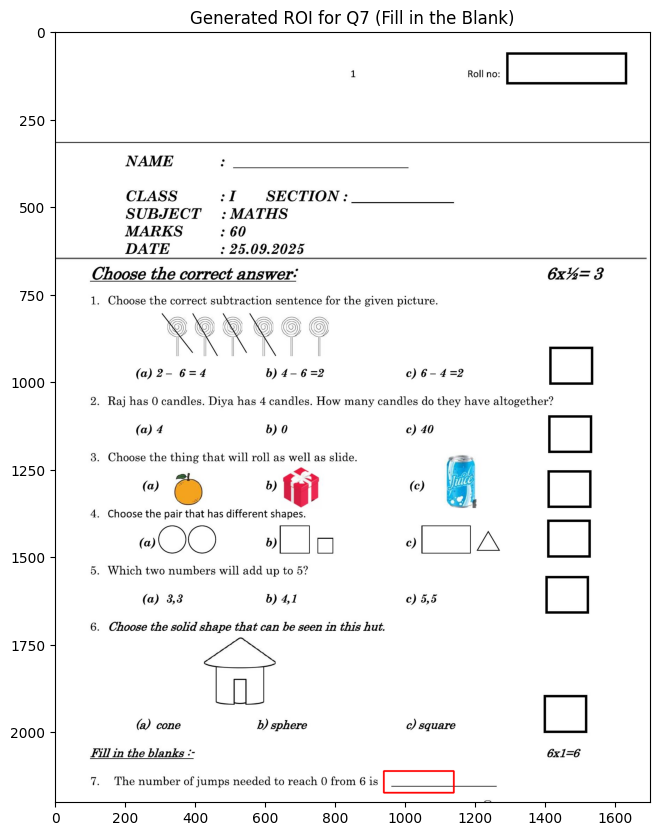

In [ ]:
# --- Step 1: Find Q7 Answer ROI (on blank template) ---

# We'll store all our answers and marks here
REFERENCE_ANSWER_KEY_FULL = {
    'Q1': 'C', 'Q2': 'A', 'Q3': 'C', 'Q4': 'C', 'Q5': 'B', 'Q6': 'A',
    'Q7': '6'  # Answer for Q7
}
MARKS_PER_Q = {
    'Q1': 0.5, 'Q2': 0.5, 'Q3': 0.5, 'Q4': 0.5, 'Q5': 0.5, 'Q6': 0.5,
    'Q7': 1.0  # Marks for Q7
}

# We load the BLANK template
template_img = cv2.imread('1.jpg')
gray = cv2.cvtColor(template_img, cv2.COLOR_BGR2GRAY)
template_with_rois = template_img.copy()

print("Running EasyOCR on blank template to find Q7...")

# 'reader' is the EasyOCR reader we initialized in Phase 0
text_results = reader.readtext(gray, paragraph=False)

q7_roi = None
# This is the "anchor text" we are looking for
target_text = "The number of jumps needed to reach 0 from 6"

for (bbox, text, prob) in text_results:
    # Check if this is the text we want
    if target_text in text:
        print(f"Found anchor text: '{text}'")

        # bbox is [[x1,y1], [x2,y1], [x2,y2], [x1,y2]]
        top_left = bbox[0]
        top_right = bbox[1]
        bottom_right = bbox[2]

        # --- Define the Answer ROI ---
        # The answer is to the RIGHT of this text, on the blank line

        # x_start: 10px to the right of the question text
        x_start = top_right[0] + 10
        # y_start: 10px above the text (to catch tall numbers)
        y_start = top_left[1] - 10
        # x_end: A 200px wide area for the answer
        x_end = x_start + 200
        # y_end: 10px below the text
        y_end = bottom_right[1] + 10

        # Store the ROI as integers
        q7_roi = (int(x_start), int(y_start), int(x_end), int(y_end))

        # Draw a RED box to visualize the new ROI
        cv2.rectangle(template_with_rois,
                      (q7_roi[0], q7_roi[1]),
                      (q7_roi[2], q7_roi[3]),
                      (0, 0, 255), 3) # Red box
        print(f"Generated Q7 Answer ROI: {q7_roi}")
        break # Stop after we find it

if q7_roi:
    display_images(template_with_rois, "Generated ROI for Q7 (Fill in the Blank)")
else:
    print("ERROR: Could not find the text 'The number of jumps...' on the template.")

SASES: Auto-Evaluation Report (EasyOCR + Inset Cropping)
Displaying the first INSET crop (Q1) being sent to EasyOCR...


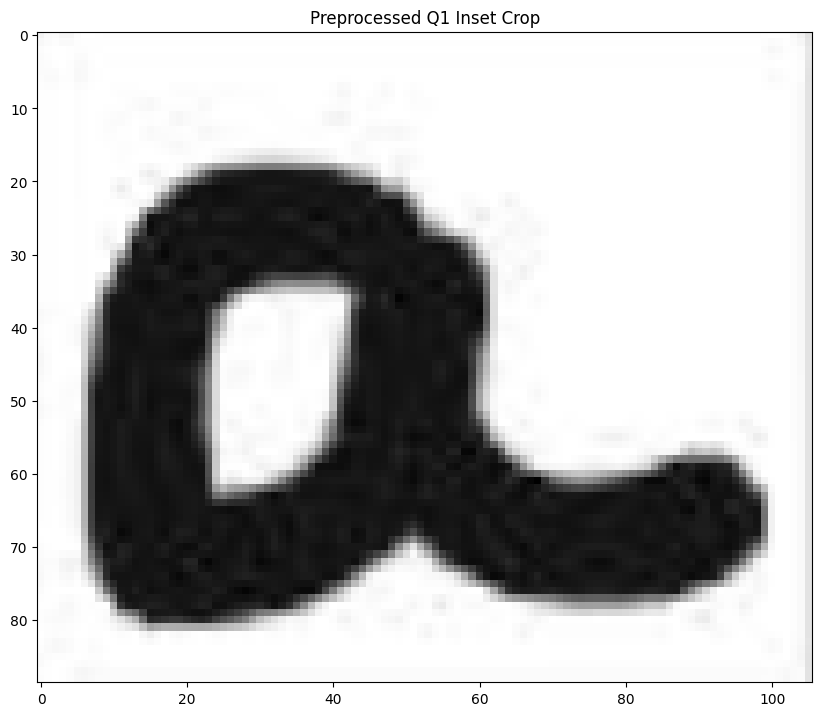

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



--- Question 1 ---
Reference: 'C' | Detected: 'A'
Result: Incorrect (Detected: 'A') | Score: 0 / 0.5

--- Question 2 ---
Reference: 'A' | Detected: ''
Result: Unanswered (EasyOCR found no text) | Score: 0 / 0.5

--- Question 3 ---
Reference: 'C' | Detected: 'B'
Result: Incorrect (Detected: 'B') | Score: 0 / 0.5

--- Question 4 ---
Reference: 'C' | Detected: 'C'
Result: Correct | Score: 0.5 / 0.5

--- Question 5 ---
Reference: 'B' | Detected: 'B'
Result: Correct | Score: 0.5 / 0.5

--- Question 6 ---
Reference: 'A' | Detected: ''
Result: Unanswered (EasyOCR found no text) | Score: 0 / 0.5

Total MCQ Score (Q1-Q6): 1.0 / 3.0


In [ ]:
# --- Final Step: Run Evaluation (EasyOCR + Inset Map) ---

# We use 'reader' (EasyOCR) we initialized in Phase 0
# We use 'REFERENCE_ANSWER_KEY' (already in memory)
# We use 'aligned_sheet' (already in memory)
# We use 'final_template_map_inset' (which we just created)

print("=========================================================")
print("SASES: Auto-Evaluation Report (EasyOCR + Inset Cropping)")
print("=========================================================")

total_score = 0
displayed_first_crop = False

for i, roi_coords in enumerate(final_template_map_inset):
    q_num = i + 1
    reference_answer = REFERENCE_ANSWER_KEY[i]

    # --- 1. CROP USING THE INSET ---
    # roi_coords are the new (x_start, y_start, x_end, y_end)
    x1, y1, x2, y2 = roi_coords
    q_crop = aligned_sheet[y1:y2, x1:x2]

    # --- 2. PREPROCESSING (Simple is best for EasyOCR) ---
    # Just convert to grayscale. EasyOCR handles thresholding internally.
    q_crop_gray = cv2.cvtColor(q_crop, cv2.COLOR_BGR2GRAY)

    # --- DEBUG DISPLAY ---
    # Show the first clean crop we send to EasyOCR
    if not displayed_first_crop:
        print("Displaying the first INSET crop (Q1) being sent to EasyOCR...")
        display_images(q_crop_gray, "Preprocessed Q1 Inset Crop")
        displayed_first_crop = True

    # --- 3. Run HWR (EasyOCR) ---
    # We use the 'allowlist' to improve accuracy
    results = reader.readtext(q_crop_gray, allowlist='abcABC')

    detected_text = ""
    q_score = 0
    q_evaluation = "Unanswered (EasyOCR found no text)"

    if results:
        # Get the first result, clean it, and uppercase it
        detected_text_raw = results[0][1]
        detected_text = "".join(filter(str.isalpha, detected_text_raw)).strip().upper()

        if not detected_text:
            q_evaluation = "Unanswered (EasyOCR found no text)"
        else:
            # Take just the first character
            detected_text = detected_text[0]
            if detected_text == reference_answer:
                q_evaluation = "Correct"
                q_score = MARKS_PER_MCQ
            else:
                q_evaluation = f"Incorrect (Detected: '{detected_text}')"
                q_score = 0

    total_score += q_score

    print(f"\n--- Question {q_num} ---")
    print(f"Reference: '{reference_answer}' | Detected: '{detected_text}'")
    print(f"Result: {q_evaluation} | Score: {q_score} / {MARKS_PER_MCQ}")

print("\n=========================================================")
print(f"Total MCQ Score (Q1-Q6): {total_score} / 3.0")
print("=========================================================")